# Frequency Dependence of System-Bath Coupling:

## Single particle in 1-D junction with exponentially decaying interactions

1. Print input parameters
2. Generate Markovian random force for step (method of Bath class)
3. EOM integration step (e.g. velocity-Verlet) (method of MD class)
    1. Include possible arguments for Markovian Langevin dynamics
        1. Dissipation
        2. Random force
4. Calculate potential energy term for given configuration (method of Interaction class)
    1. Exponentially decaying interaction function
    2. Harmonic Oscillator
5. Calculate heat current and conductivity during a given step (method of MD class)
6. Print output results

Useful links:
1. http://codepad.org/FcbFcoue
2. http://gdrcorelec.ups-tlse.fr/files/python_verlet.pdf
3. http://docs.scipy.org/doc/numpy/reference/routines.html

Further reading:
1. http://stackoverflow.com/questions/15374291/writing-a-faster-python-physics-simulator/15375757#15375757
2. http://dirac.cnrs-orleans.fr/MMTK/using-mmtk/mmtk-example-scripts/molecular-dynamics/an-md-integrator-written-in-python
3. https://github.com/WeatherGod/AnatomyOfMatplotlib

## System units:

1. Characteristic distance = 1 $\AA$ (Angstrom)
2. Characteristic mass = 1 a.m.u.
3. Characteristic energy ~ 100 cm$^{-1}$
4. Time = 1/ (100 cm$^{-1}$ $\times$ c [cm / s]) s = 1 / 29979245800 s = 33.35641e-12 s = 33.35641 ps
5. Temperature = (100 cm$^{-1}$ $\times$ $k_B$) Kelvin = 144 Kelvin
    * $k_B$ = $1.38064 \times 10^{-23}$ J/K (Boltzmann constant in SI units)

### Derived units:

1. Speed = 1 Angstrom / 33.35641 ps = 1 Angstrom $\times$ 0.029979245800 ps$^{-1}$ = 0.029979245800 Angstrom / ps
2. Acceleration = 0.029979245800 Angstrom / ps $\times$ 0.029979245800 ps$^{-1}$ = 0.0008987551787 Angstrom / ps$^{-2}$
3. Momentum = 1 a.m.u. $\times$ 0.029979245800 Angstrom / fs = 0.029979245800 a.m.u. $\times$ Angstrom / ps

## Pylab magic:

In [43]:
# magic!
%pylab inline

##from math import exp
#import math

import time
import itertools

##from numpy import array, ndarray # dev note: why can't I import like this?
#import numpy as np

#import matplotlib.pyplot as plt
##from matplotlib import pyplot as plt
##import matplotlib as mpl
#"""
#try:
#    import matplotlib.pyplot as plt
#except:
#    raise
#"""

# from random import gauss

Populating the interactive namespace from numpy and matplotlib


## Global constants:

In [44]:
"""
System units:
length: 1 Angstrom
mass: 1 a.m.u.
time: from energy, using c
energy: 100 wavenumbers
"""
"""
energy scale ~ 100 wavenumbers
"""
WAVENUMBER_TO_SYS_UNITS = 1e-2
"""
100 wavenumbers ~= 3e12 Hz
==> linear frequency scale ~ 3 PHz
"""
"""
3e12 Hz ~= 18.85e12 rad / s
==> angular frequency scale ~ 2e13 rad/s
"""
"""
3e12 Hz ~= (33.3e-12 s)^(-1) = (33.3 picoseconds)^(-1)
==> time scale ~ 33.3 ps
"""
#SECONDS_TO_SYS_UNITS = float(100) / 3e-12 # float(1) / (33.3e-12)
PICOSECONDS_TO_SYS_UNITS = float(100) / 3
"""
100 wavenumbers ~= 144 Kelvin
==> temperature scale ~ 144 Kelvin
"""
KELVIN_TO_SYS_UNITS = float(1) / 144
"""
mass scale ~ 1 a.m.u.
"""

'\nmass scale ~ 1 a.m.u.\n'

## Declaration of global variables:

In [45]:
N_DIM=1 # spatial dimensionality
N_ATOMS=3 # number of atoms in extended molecule (including surfaces of left and right bulk solids)

M0=1 # mass of particle, in a.m.u. (attribute of Particle class)
m=np.ones(N_ATOMS) # mass of each atom, in a.m.u.
x=np.zeros(shape=(N_ATOMS, N_DIM)) # position of each atom, in Angstroms
v=np.zeros(shape=(N_ATOMS, N_DIM)) # velocitiy of each atom, in Angstroms per picosecond
a=np.zeros(shape=(N_ATOMS, N_DIM)) # acceleration of each atom, in Angstroms per picosecond squared

binaryForces=np.zeros(shape=(N_ATOMS,N_ATOMS))

M_B=1 # mass of surface-representation particle, in a.m.u. (attribute of Particle class)
V0=0 # magnitude of particle-surface interaction, in wavenumbers (attribute of Interaction class)
INV_A=1 # exponentially decaying interaction length in Angstroms (attribute of Interaction class)
HARMONIC_APPROX=False # true if the harmonic approximation is to be taken
GAMMA_B=0 # coupling strength of surface-representation particle to respective bath, in wavenumbers (attribute of BathInteraction class)
OMEGA_B=1 # oscillation frequecy of surface-representation particle, in wavenumbers (attribute of Interaction class)

T_R=0 # temperature of the cold bath, in Kelvin (attribute of Bath class)
DELTA_T=0 # temperature bias between the baths, in Kelvin
T_L=0 # temperature of the hot bath, in Kelvin

dt=1 # duration of each time step, in picoseconds
slow_component_period=1
STEPS_PER_PERIOD=50
N_SLOW_PRIODS=(320) * 4
n_steps=1 # numer of time steps
t=0 # simulated time, in time-steps

COARSE_GRAINING_RESOLUTION=1 # show phase data every (n_steps / COARSE_GRAINING_RESOLUTION) steps
t_n=0 # coarse-graining segment
x0t=np.zeros(shape=(2, N_ATOMS))
v0t=np.zeros(shape=(2, N_ATOMS))

E=np.zeros(shape=(2, N_ATOMS))
T=np.zeros(shape=(2, N_ATOMS))
Esys=np.zeros(2)
Psys=np.zeros(2)

IS_DEBUG=False

## Initialization:

In [46]:
def init_Topology():
    global N_DIM
    N_DIM = 1
    global N_ATOMS
    N_ATOMS = 3

def init_Time(steps=0):
    global dt
    dt = float(1) / max(V0 * INV_A, OMEGA_B)
    # dt = float(1 / (2 * math.pi)) / max(V0 * INV_A, OMEGA_B) # accept PEP 628 !    
    dt /= STEPS_PER_PERIOD
    print("dt = {} ps".format(dt / PICOSECONDS_TO_SYS_UNITS))
    
    slow_component_period = float(1) / min(V0 * INV_A, OMEGA_B if (0 < OMEGA_B) else V0 * INV_A)
    if (0 == slow_component_period):
        raise Exception("slow component period cannot be zero!")
    print("slow_component_period = {} ps".format(slow_component_period / PICOSECONDS_TO_SYS_UNITS))
    
    global n_steps
    n_steps = int(N_SLOW_PRIODS * slow_component_period / dt)
    if(0 != steps):
        if(n_steps > steps):
            n_steps = steps
    print("n_steps = {}".format(n_steps)    )
    
    if (1 >= n_steps):
        raise Exception("trivial number of time-steps. No point in continuing...")
    
    MAX_ALLOWED_TIME_STEPS = 1e6
    if (MAX_ALLOWED_TIME_STEPS < n_steps):
        raise Exception("expected number of time steps is too large! {0} > {1}".format(n_steps, MAX_ALLOWED_TIME_STEPS))
    
    global t
    t = 0
    
    print("Time initialization completed")
    
def init_Particles():
    global M0
    M0 = 16
    
    global m
    m = np.ones(N_ATOMS) * M0   
    print("[m] = {0}, dim(m) ={1}".format(type(m), m.shape))
    
def init_PhaseData():
    global x
    x = np.zeros(shape=(N_ATOMS, N_DIM))
    # x[i:0] = np.arange(N_ATOMS)[i]
    for i in range(N_ATOMS):
        x[i,0] = INV_A * i # set at equilibrium positions
    x[0,0] += float(INV_A / 100) # initial displacement...
    print("[x] = {0}, dim(x) ={1}".format(type(x), x.shape))
    
    global v
    v = np.zeros(shape=(N_ATOMS, N_DIM))
    print("v[:,0] = {}".format(v[:,0]))

    global a
    a = np.zeros(shape=(N_ATOMS, N_DIM))
    print("a[:,0] = {}".format(a[:,0]))

    print("PhaseData initialization completed")

def init_MD():
    init_Topology()
    init_Time()
    init_Particles()
    init_PhaseData()
    init_Output()
    print("MD initialization completed")

In [47]:
def init_Output_CoarseGraining():
    global COARSE_GRAINING_RESOLUTION
    MAX_PLOT_POINTS = 300 # Important! Don't over-do it so as not to overload the CPU
    if(MAX_PLOT_POINTS < n_steps):
        COARSE_GRAINING_RESOLUTION = int(n_steps / MAX_PLOT_POINTS)
    if COARSE_GRAINING_RESOLUTION > n_steps:
        # raise Exception("COARSE_GRAINING_RESOLUTION ({0}) cannot be greater than n_steps ({1})!".format(COARSE_GRAINING_RESOLUTION, n_steps))
        COARSE_GRAINING_RESOLUTION = min(COARSE_GRAINING_RESOLUTION, n_steps)
    if (1 > COARSE_GRAINING_RESOLUTION):
        COARSE_GRAINING_RESOLUTION = 1
    print("COARSE_GRAINING_RESOLUTION = {0}".format(COARSE_GRAINING_RESOLUTION))
    
    global t_n
    t_n = 0

def init_Output_PhaseData():
    global x0t    
    x0t=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_ATOMS))
    """
    for i in range(N_ATOMS):
        x0t[0,i] = x[i,0]
    """
    """
    x0t[0] = x[:,0].transpose()
    """
    print("x0t.shape =", x0t.shape)
    
    global v0t
    v0t=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_ATOMS))
    """
    for i in range(N_ATOMS):
        v0t[0,i] = v[i,0]
    """
    print("v0t.shape =", v0t.shape)

    
    if(x0t.shape != v0t.shape):
        raise Exception("coarse-grained phase data must have the same dimensionality for both position ({0}) and momentum ({1})!".format(x0t.shape, v0t.shape))
    
def init_Output_Mechanics():
    global Psys
    Psys=np.zeros(2 + n_steps / COARSE_GRAINING_RESOLUTION)
    for i in range(N_ATOMS):
        Psys[0] += m[i] * v[i,0]
    
def init_Output_Energetics():
    global E, Esys
    E=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_ATOMS))
    Esys=np.zeros(2 + n_steps / COARSE_GRAINING_RESOLUTION)
    for i in range(N_ATOMS):
        E[0, i] = calcAtomEnergy(i)
        Esys[0] += E[0, i]
          
def init_Output_Thermodynamics():
    global T
    T=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_ATOMS))
    """
    for i in range(N_ATOMS):
        T[0, i] = m[i] * np.dot(v[i],v[i]) * KELVIN_TO_SYS_UNITS
    """
    print("T[0] = {}".format(T[0]))
        
def init_Output():
    init_Output_CoarseGraining()
    init_Output_PhaseData()
    init_Output_Mechanics()
    init_Output_Energetics()
    init_Output_Thermodynamics()
    print("Outputs initialization completed")

In [48]:
def init_Interaction():
    global V0
    V0 = float(8000)
    V0 *= WAVENUMBER_TO_SYS_UNITS
    print("{0} = {1} cm{2}".format(str(r'$V_0$'),V0 / WAVENUMBER_TO_SYS_UNITS, str(r'$^{-1}$')))
    
    global INV_A
    INV_A = float(1)
    print("{0} = {1} cm{2}".format(str(r'a$^{-1}$'),INV_A, str(r'$\AA$')))
    
    global HARMONIC_APPROX
    HARMONIC_APPROX = False

def init_Bath(isColdBath, temperature):
    global T_R
    if(isColdBath):
        T_R = temperature
        T_R *= KELVIN_TO_SYS_UNITS
    else:
        DELTA_T = temperature
        DELTA_T *= KELVIN_TO_SYS_UNITS
        global T_L
        T_L = T_R + DELTA_T
        
    print("{0} = {1}".format("T_R" if isColdBath else "T_L", T_R if isColdBath else T_L))

def init_Baths():
    global M_B
    M_B = 16
    
    global OMEGA_B
    OMEGA_B = 0 # float(400)
    OMEGA_B *= WAVENUMBER_TO_SYS_UNITS
    print("{0} = {1} cm{2}".format(str(r'$\Omega_B$'), OMEGA_B / WAVENUMBER_TO_SYS_UNITS, str(r'$^{-1}$')))
    
    global GAMMA_B
    GAMMA_B = float(0)
    GAMMA_B *= WAVENUMBER_TO_SYS_UNITS
    print("{0} = {1} cm{2}".format(str(r'$\Gamma_B$'), GAMMA_B / WAVENUMBER_TO_SYS_UNITS, str(r'$^{-1}$')))
    
    global T_R
    init_Bath(True, T_R)
    
    global DELTA_T
    init_Bath(False, DELTA_T)
    
    print("Baths initialization completed")

In [49]:
def init():    
    print("initialization in progress:")
    init_Baths()
    init_Interaction()
    init_MD()
    print("initialization completed")

## Interaction and derived functions:

In [50]:
def generateMarkovianRandomForce(isColdBath):
    # random.random() # draw random number from the uniform distribution over the range [0.0, 0.1)
    global T_L, T_R, M_B, GAMMA_B
    T_K = T_R if isColdBath else T_L
    sigma_sq = 2 * M_B * GAMMA_B * T_K
    if (0 == sigma_sq):
        return 0
    # print  "DEBUG:", M_B, GAMMA_B, T_K, sigma_sq, random.gauss(0, sigma_sq)
    return np.random.normal(0, sigma_sq)


def calcInteraction(x, isHarmonic):
    global V0, INV_A
    if isHarmonic:
        return (V0 / (INV_A * INV_A)) * pow((abs(x) - INV_A),2)
    
    try:
        return V0 * math.exp(-1. * abs(x) / INV_A)
    except OverflowError as e:
        raise OverflowError(e, x, V0, INV_A)        
        
def calcForce(x_this, x_that, isHarmonic, isDebug=False):
    # dev note: save previously calculated binary interaction pairs to cut calculations by half
    global INV_A
    
    d = x_that - x_this
    V = calcInteraction(d, isHarmonic)
    
    if isHarmonic:
        if(0 == d):
            f = 0
        else:
            f = -1. * V / d
    else:
        if(0 == d):
            raise Exception("Pauli exclusion exception! x_this = {0} == {1} = x_that".format(x_this, x_that))

        f = (-1. / INV_A) * V * (d / abs(d))
    
    if(isDebug):
        print("x_this = {0}, x_that = {1}, d = {2}, isHarmonic = {3}, V = {4}, f = {5}".format(x_this, x_that, d, isHarmonic, V, f))
    
    return f

def calcBathForce(v, isColdBath):
    '''
    @todo memoize e.g. F_12 to be recalled instead of recalculating F_21
    '''
    global M_B, OMEGA_B, GAMMA_B
    
    # no coupling
    if(0 == GAMMA_B):
        return 0
    
    # Markovian bath
    if(0 == OMEGA_B):
        return generateMarkovianRandomForce(isColdBath) - M_B * GAMMA_B * v
    
    return 0 # todo: Non-Markovian bath interaction (save prevBathForce)

def calcPositionRestraint(isColdBath, isDebug=False):
    if(isColdBath):
        """
        if((INV_A / 1e2) > abs(x[i]))):
            return 0
        """
        return calcForce(x[i], -1. * INV_A, isHarmonic=True, isDebug=isDebug)
    """
    if ((INV_A / 1e3) > abs((INV_A * (N_ATOMS - 1)) - x[i])):
        return 0
    """
    return calcForce(x[i], INV_A * N_ATOMS, isHarmonic=True, isDebug=isDebug)

## Mechanics:

In [51]:
def calcNetForce(i, isDebug=False):
    global N_ATOMS, HARMONIC_APPROX, binaryForces
    f = float(0)
    for j in range(N_ATOMS):
        
        if(i == j):
            continue

        if(j > i):
            
            try:
                binaryForces[i,j] = calcForce(x[i], x[j], HARMONIC_APPROX, isDebug)
            except OverflowError as e:
                raise OverflowError(e, i, x[i], j, x[j], f)            
            
            f += binaryForces[i,j]
            continue
        
        f -= binaryForces[j,i]

    if((0 == i) or ((N_ATOMS - 1) == i)):
        # print "DEBUG: ", i, v[i], calcBathForce(v[i], N_ATOMS - 1 == i)
        f += calcBathForce(v[i], N_ATOMS - 1 == i)
        f += calcPositionRestraint(0 == i, isDebug)
    return f

## Kinematics:

In [52]:
def calcAcceleration(i):
    global m
    return calcNetForce(i) / m[i]


def velocityVerlet(i, isDebug=False):
    '''
    This form assumes calcuation of acceleration depends only on position, and not on velocity
    '''
    global x, v, a, dt
    x_full = x[i] + v[i] * dt + 0.5 * a[i] * dt * dt
    x[i] = 0.5 * (x[i] + x_full)
    a_full = calcAcceleration(i)
    v[i] += 0.5 * (a[i] + a_full) * dt    
    
    if(isDebug):
        print("x_full = {0} , a_full = {1}".format(x_full, a_full))
    
    return (x_full, v[i])

## Conservation:

In [53]:
def calcAtomEnergy(i):
    global m, x, v
    retval = m[i] * abs(v[i]) * abs(v[i])
    for j in range(N_ATOMS):
        
        if (i == j):
            continue
        
        try:
            retval += calcInteraction(x[j] - x[i], HARMONIC_APPROX)
        except OverflowError as e:
            raise OverflowError(e, i, x[i], j, x[j], retval)
            
        # if((0 == i) or ((N_ATOMS - 1) == i)): calc bath interaction energy
    
    return retval

def calcSystemEnergy():
    tot = 0
    for i in range(N_ATOMS):
        tot += calcAtomEnergy(i)
    return tot

def calcSystemMomentum():
    global m, v
    tot = np.zeros(shape=(N_DIM))
    for i in range(N_ATOMS):
        tot += m[i] * v[i].transpose
    return tot

## Heat current:

In [54]:
def calcHeatCurrent():
    global N_ATOMS, x, v
    heatCurrent=0    
    for i in range(N_ATOMS - 1):
       heatCurrent += 0.5 * binaryForces[i, i+1] * (v[i] + v[i+1])
    return heatCurrent

def calcHeatConductivity():
    global DELTA_T
    if(0 == DELTA_T):
        raise Exception("Zero temperature gradient -- can't calculate conductivity!")
    return calcHeatCurrent() / DELTA_T

def calcDiffHeatConductivity():
    pass

## Output:

In [55]:
def printPhaseConfiguration():
    global N_ATOMS, dt, t, t_n, x, x0t, v
    print
    for i in range(N_ATOMS):
        # print "t =", t, "; i =", i, "; x[i] =", x[i], "; v[i] =", v[i]
        print("t = {0:f}, t_n - 1 = {1:f}, i = {2:d}, x[i] = {3}, <x[i]> = {4}, v[i] = {5}".format(t * dt / PICOSECONDS_TO_SYS_UNITS, (t_n - 1) * dt / PICOSECONDS_TO_SYS_UNITS, i, x[i], x0t[t_n - 1,i], v[i]))

def redrawSubplot(ax=None):
    if(None == ax):
        ax = plt.gca()  # get the current axes
    ax.relim()      # make sure all the data fits
    ax.autoscale()  # auto-scale
    # ax.draw()       # re-draw the figure

def plotTrajectory():
    global N_ATOMS, t, n_steps, COARSE_GRAINING_RESOLUTION, x0t, v0t
    #plt.plot(t, x0t, c=range(N_ATOMS), alpha=0.5)
    
    # object-oriented pyplot
    fig = plt.figure(figsize=(12, 12), dpi=300)
    fig.suptitle('Frequency Dependence of System-Bath Coupling')

    n_segments = int(n_steps / COARSE_GRAINING_RESOLUTION)
    t_max = n_segments * COARSE_GRAINING_RESOLUTION * dt / PICOSECONDS_TO_SYS_UNITS
    t_grid = np.linspace(0, t_max, n_segments)
    
    atom_series_colors = itertools.cycle(cm.hsv(np.linspace(0, 1, N_ATOMS + 1)))
    
    print("plotting x(t)")
    ax1 = fig.add_subplot(6,1,1)
    ax1.set_title('Trajectory: x[0,i] vs. t, for all i in (1,N_ATOMS)')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel(r'x/[$\AA$]') # use raw string and latex
    
    for i in range(N_ATOMS):
        series_label = '_'.join(["x", str(i)])
        atom_color=next(atom_series_colors)
        # for t_n in range(n_segments):
        ax1.scatter(
            t_grid,
            x0t[:-2,i],
            color=atom_color,
            s=5,
            cmap=plt.cm.cool,
            alpha=0.5,
            label=series_label)
    # float(t_n) * COARSE_GRAINING_RESOLUTION * dt / PICOSECONDS_TO_SYS_UNITS,
    # plt.legend(['x_{}(t)'.format(i) for i in range(N_ATOMS)], loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=11)
    plt.legend(['x_{}(t)'.format(i) for i in range(N_ATOMS)])
    next(atom_series_colors)
    
    print("plotting v(x)")
    ax1 = fig.add_subplot(6,1,2)
    ax1.set_title('Phase-space trajectory: v[0,i] vs. x[0,i], for all i in (1,N_ATOMS)')
    plt.xlabel(r'x/[$\AA$]')
    plt.ylabel(r'v/[$\AA$ / ps]')
    for i in range(N_ATOMS):
        series_label = '_'.join(["v", str(i)])
        atom_color = next(atom_series_colors)
        for t_n in range(1, n_segments):
            ax1.scatter(
                x0t[t_n, i],
                v0t[t_n, i] / PICOSECONDS_TO_SYS_UNITS,
                color=atom_color,
                s=5,
                alpha=0.5,
                label=series_label)

    next(atom_series_colors)
    
    print("plotting T_i(t)")
    ax1 = fig.add_subplot(6,1,3)
    ax1.set_title('Atomic temperatures: T[i] vs. t, for all i in (1,N_ATOMS)')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel('T/[K]')
    for i in range(N_ATOMS):
        series_label = '_'.join(["T", str(i)])
        series_color = next(atom_series_colors)
        #for t_n in range(1, n_segments):
        ax1.scatter(
            t_grid,
            T[:-2, i] / KELVIN_TO_SYS_UNITS,
            color=series_color,
            s=5,
            alpha=0.5,
            label=series_label)

    next(atom_series_colors)
    
    print("plotting E_i(t)")
    ax1 = fig.add_subplot(6,1,4)
    ax1.set_title('Atomic energies: E[i] vs. t, for all i in (1,N_ATOMS)')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel('E/[cm$^{-1}$]')
    for i in range(N_ATOMS):
        series_label = '_'.join(["E", str(i)])
        series_color = next(atom_series_colors)
        #for t_n in range(1, n_segments):
        ax1.scatter(
            t_grid,
            E[:-2, i] / WAVENUMBER_TO_SYS_UNITS,
            color=series_color,
            s=5,
            alpha=0.5,
            label=series_label)

    next(atom_series_colors)
    
    print("plotting E(t)")
    ax1 = fig.add_subplot(6,1,5)
    ax1.set_title('System energy: E vs. t')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel('E/[cm$^{-1}$]')
    #for t_n in range(1, int(n_steps / COARSE_GRAINING_RESOLUTION)):
    ax1.scatter(
        t_grid,
        Esys[:-2] / WAVENUMBER_TO_SYS_UNITS,
        s=5,
        alpha=0.5,
        label='E_sys')
    
    print("plotting P(t)")
    ax1 = fig.add_subplot(6,1,6)
    ax1.set_title('System momentum: P vs. t')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel(r'P/[a.m.u. $\AA$ / ps')
    #for t_n in range(1, n_segments):
    ax1.scatter(
        t_grid,
        Psys[:-2],
        s=5,
        alpha=0.5,
        label='P_sys')

    try:
        fig.tight_layout()        
        #fig.tight_layout(pad=2, w_pad=2, h_pad=2) # Don't over-do it
        #fig.tight_layout(w_pad=8, h_pad=4)
    except:
        pass

    plt.subplots_adjust(top=0.9)
    print("displaying plots:")
    plt.show()

## Runner

In [56]:
def MD_Runner():
    global t_n
    
    REPORT_TIMES=20

    for t in range(n_steps):

        for i in range(N_ATOMS):

            try:
                x[i], v[i] = velocityVerlet(i, isDebug=IS_DEBUG)
            except OverflowError as exptn:
                raise OverflowError(exptn, t, i, x[i], v[i])    

            x0t[t_n,i] += x[i,0]
            v0t[t_n,i] += v[i,0]
            E[t_n, i] += calcAtomEnergy(i)
            if(0 == t % COARSE_GRAINING_RESOLUTION):

                x0t[t_n,i] /= COARSE_GRAINING_RESOLUTION
                v0t[t_n,i] /= COARSE_GRAINING_RESOLUTION
                E[t_n, i] /= COARSE_GRAINING_RESOLUTION

                T[t_n, i] = m[i] * 3 * pow(v0t[t_n,i], 2)
                Esys[t_n] += E[t_n, i]
                Psys[t_n] = m[i] * v0t[t_n,i]

                if(N_ATOMS - 1 == i):
                    t_n += 1

        if(30 > n_steps) or (0 == t % (n_steps / REPORT_TIMES) or (3 > t)):

            timer = time.clock()
            if(0 == t):            
                start_timer = timer
                time_left = "unknown time"
            else:
                time_left = datetime.timedelta(seconds=((timer - prev_timer) * REPORT_TIMES * (1 - t / n_steps)))
                # print("DEBUG: t = {0}, timer = {1}, prev_timer = {2}, time_left = {3}".format(t, timer, prev_timer, time_left))            
            prev_timer = timer

            print("{0}% done, {1} left".format(int(100. * t / n_steps),  time_left))
            printPhaseConfiguration()
            sys.stdout.flush()

        if(0 != DELTA_T):
            calcHeatConductivity()

## NVE

In [57]:
init()

initialization in progress:
$\Omega_B$ = 0.0 cm$^{-1}$
$\Gamma_B$ = 0.0 cm$^{-1}$
T_R = 0.0
T_L = 0.0
Baths initialization completed
$V_0$ = 8000.0 cm$^{-1}$
a$^{-1}$ = 1.0 cm$\AA$
dt = 7.499999999999999e-06 ps
slow_component_period = 0.000375 ps
n_steps = 64000
Time initialization completed
[m] = <class 'numpy.ndarray'>, dim(m) =(3,)
[x] = <class 'numpy.ndarray'>, dim(x) =(3, 1)
v[:,0] = [ 0.  0.  0.]
a[:,0] = [ 0.  0.  0.]
PhaseData initialization completed
COARSE_GRAINING_RESOLUTION = 213
x0t.shape = (302, 3)
v0t.shape = (302, 3)
T[0] = [ 0.  0.  0.]
Outputs initialization completed
MD initialization completed
initialization completed


In [58]:
print("Initial configuration for {0} atoms in {1} dimensions:".format(N_ATOMS, N_DIM))
np.set_printoptions(precision=3)
printPhaseConfiguration()

Initial configuration for 3 atoms in 1 dimensions:
t = 0.000000, t_n - 1 = -0.000007, i = 0, x[i] = [ 0.01], <x[i]> = 0.0, v[i] = [ 0.]
t = 0.000000, t_n - 1 = -0.000007, i = 1, x[i] = [ 1.], <x[i]> = 0.0, v[i] = [ 0.]
t = 0.000000, t_n - 1 = -0.000007, i = 2, x[i] = [ 2.], <x[i]> = 0.0, v[i] = [ 0.]


In [59]:
print("Running",n_steps,"time-steps")

Running 64000 time-steps


In [60]:
MD_Runner()

0% done, unknown time left
t = 0.000000, t_n - 1 = 0.000000, i = 0, x[i] = [ 0.01], <x[i]> = 4.694835680751174e-05, v[i] = [ 0.001]
t = 0.000000, t_n - 1 = 0.000000, i = 1, x[i] = [ 1.], <x[i]> = 0.004694835680751174, v[i] = [  2.311e-06]
t = 0.000000, t_n - 1 = 0.000000, i = 2, x[i] = [ 2.], <x[i]> = 0.009389671361502348, v[i] = [ 0.]
0% done, 0:00:00.065766 left
t = 0.000000, t_n - 1 = 0.000000, i = 0, x[i] = [ 0.01], <x[i]> = 4.694835680751174e-05, v[i] = [ 0.001]
t = 0.000000, t_n - 1 = 0.000000, i = 1, x[i] = [ 1.], <x[i]> = 0.004694835680751174, v[i] = [  4.622e-06]
t = 0.000000, t_n - 1 = 0.000000, i = 2, x[i] = [ 2.], <x[i]> = 0.009389671361502348, v[i] = [ 0.001]
0% done, 0:00:00.080890 left
t = 0.000000, t_n - 1 = 0.000000, i = 0, x[i] = [ 0.01], <x[i]> = 4.694835680751174e-05, v[i] = [ 0.002]
t = 0.000000, t_n - 1 = 0.000000, i = 1, x[i] = [ 1.], <x[i]> = 0.004694835680751174, v[i] = [  6.932e-06]
t = 0.000000, t_n - 1 = 0.000000, i = 2, x[i] = [ 2.], <x[i]> = 0.009389671361

In [61]:
print("Final configuration:")
printPhaseConfiguration()

Final configuration:
t = 0.000000, t_n - 1 = 0.002250, i = 0, x[i] = [ -2.007e+08], <x[i]> = -185096742.3146348, v[i] = [ -3.173e+08]
t = 0.000000, t_n - 1 = 0.002250, i = 1, x[i] = [-29.658], <x[i]> = -29.538913893375916, v[i] = [-2.324]
t = 0.000000, t_n - 1 = 0.002250, i = 2, x[i] = [ -2.007e+08], <x[i]> = -185134159.0000142, v[i] = [ -3.174e+08]


In [62]:
simulated_time = n_steps * dt / PICOSECONDS_TO_SYS_UNITS
simulation_duration = timer - start_timer
print("simulated time = {} ps\nsimulation wall-clock duration = {}".format(simulated_time, datetime.timedelta(seconds=simulation_duration)))

time_dilation_ratio = 1e12 * simulation_duration / simulated_time
print("time dilation = {:.1e}%\n{:.3g} ps per minute".format(100. * time_dilation_ratio, 60 * 1e12 / time_dilation_ratio))

simulated time = 0.48 ps
simulation wall-clock duration = 0:00:19.620427
time dilation = 4.1e+15%
1.47 ps per minute


plotting x(t)
plotting v(x)
plotting T_i(t)
plotting E_i(t)
plotting E(t)
plotting P(t)
displaying plots:


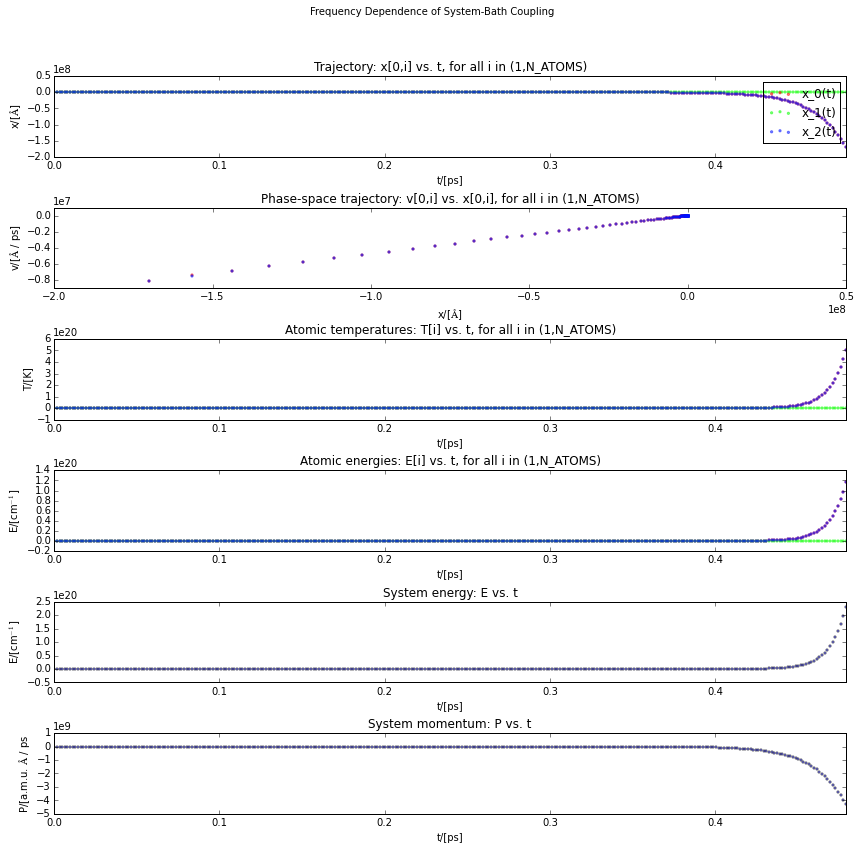

In [63]:
plotTrajectory()